# Transfer Entropy

This notebook will estimate the transfer entroy of the coulpled time series from scratch

> Xt = 0.5Xt-1 + et


> yt = c*Xt-1 + 0.5*yt-1 + et

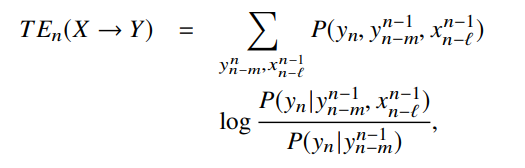


It can equivalently be expressed as - <br>
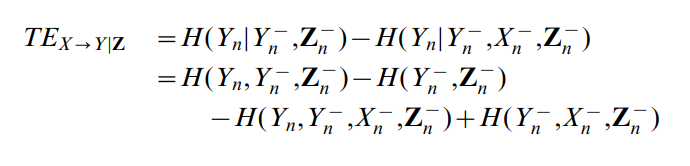

We need to find how many values of Y- and X- to include in the calculation. For this we perform autocorrelation and partial autocorrelation.


In [ ]:
from math import sin, pi, sqrt, ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import copy
import os
os.getcwd() # use this to find cs file

'/content'

In [ ]:
# Coupled System to estimate transfer entropy

def generate_data(n_instances):
  X, y=[0.5],[0.5]
  for i in range(1, n_instances+1):
    X.append((0.5*X[i-1]) + np.random.normal(0, 1))
    y.append(0.5*X[i-1] + 0.5*y[i-1] + np.random.normal(0, 1))

  X_series=pd.Series(X)
  y_series=pd.Series(y)

  df=pd.DataFrame({'X':X_series, 'y':y_series})
  df.to_csv('Coupled Time Series Data.csv', index=False)

  # plot the time series individualy
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  time = np.arange(0, n_instances+1)
  
  ax1.plot(time, X_series)
  ax1.set_title('Time Seies - X')

  ax2.plot(time, y_series)
  ax2.set_title('Time Seies - y')

  fig.text(0.5, 0.04, 'Time', ha='center')
  fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

  plt.show()

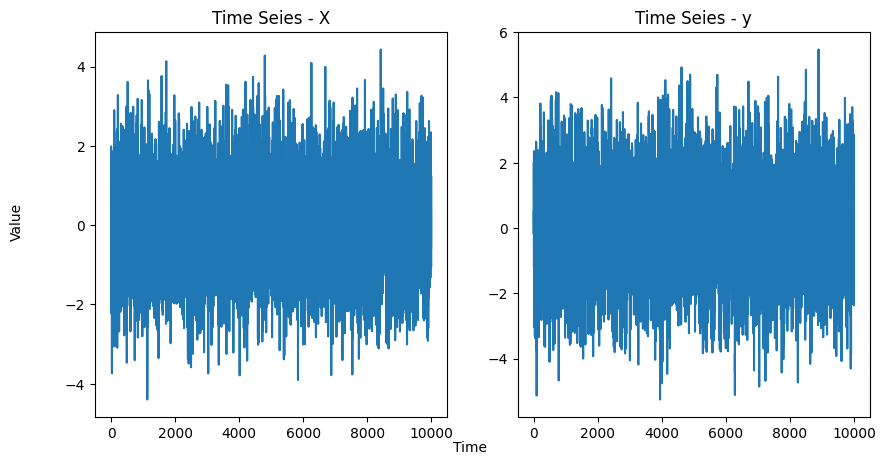

In [ ]:
n_instances=10000
generate_data(n_instances)

# Calculating the Optimal Delay and Order
Next step is to compute the delay of the source series X and the order of the targer series y.
<br>To calculate delay we use the autocorrelation function and to calculate the order we use partial autocorrelation function

# Autocorrelation
It measures the correlation of Xt and Xt-k without removing the effects of previous lags. We will use it while estimating the shannon entropy of target series conditioned on its own previous values and previous(delay) values of the source series


> ACF(k) = (1/N) * sum((X(t) - mu)*(X(t-k) - mu)) / sigma^2
<br> N is the length of the time series, k is the lag, sigma is standard deviation and mu is mean of series

Good resource for autocorrelation and partial autocorrelation - https://www.youtube.com/watch?v=ZjaBn93YPWo&ab_channel=BrandonRohrer


# Partial Autocorrelation
It is the correlation between two lags of a time series after removing the effects of the intermediate lags. 

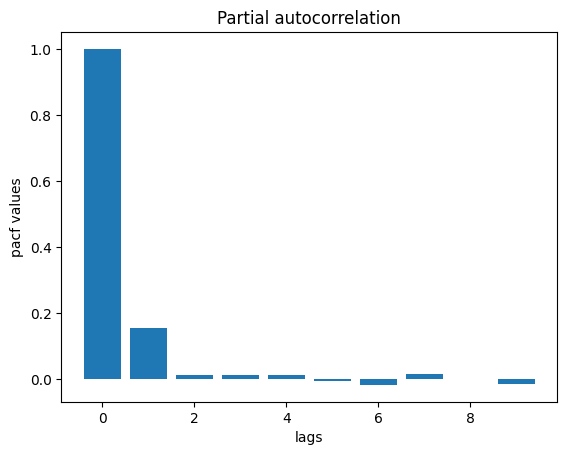

In [ ]:
pacf = []
nlags = 10

df = pd.read_csv('Coupled Time Series Data.csv')

y = df['y'].to_numpy()
ys = copy.deepcopy(y)
residuals = ys

for shift in range(nlags):
  if(shift == 0):
    pacf.append(np.corrcoef(ys, residuals)[0,1])
  else:
    pacf.append(np.corrcoef(ys[:-shift], residuals[shift:])[0,1])

  if(shift == 0):
    slope, intercept = np.polyfit(y, residuals, 1)
    estimate = intercept + slope * ys
  else:
    slope, intercept = np.polyfit(ys[:-shift], residuals[shift:], 1)
    estimate = intercept + slope * ys[:-shift]

  residuals[shift:] = residuals[shift:] - estimate

lags = np.arange(nlags)
plt.bar(lags, pacf)
plt.xlabel('lags')
plt.ylabel('pacf values')
plt.title('Partial autocorrelation')
plt.show()

The pacf of lag 1 is 0.5 and for rest is negligible. This tells us that the present of y is influenced by just the previous of y. We will include only this term in the probability distributiin that we estimate. (pacf of lag 0 is the correlation of the time series with itself. Thus it has value 1)

# Estimating the Joint Probability Density Function using Uniform Binning
To calculate transfer entropy we need to know the joint probability function. We use binning to estimate the pdf. We create 'bins' and map each point to a bin. The number of points in a bin is used to estimate probability.


In [ ]:
# calculate shannon entropy of yt, yt-1, xt-1

yt        = df['y'].to_numpy()[1:].reshape(-1, 1)
yt_minus1 = df['y'].to_numpy()[:-1].reshape(-1, 1)
Xt_minus1 = df['X'].to_numpy()[:-1].reshape(-1, 1)

# concatenate to make the sample matrix
sample = np.hstack((yt, yt_minus1, Xt_minus1))
print(sample.shape)

series_len = len(yt)
# calculate number of bins using struges formulae

#### set bin count ####
# num_bins = int(ceil(np.log2(series_len))) + 1
set_bins = [2, 3, 5, 8, 13, 21, 34, 55, 89]
num_bins = set_bins[2]

p_yt_yt_minus1_Xt_minus1, edges = np.histogramdd(sample, bins = (num_bins, num_bins, num_bins))
p_yt_yt_minus1_Xt_minus1 /= np.sum(p_yt_yt_minus1_Xt_minus1)

H_yt_yt_minus1_Xt_minus1 = 0
# calculate the shannon entropy
for i in range(num_bins):
  for j in range(num_bins):
    for k in range(num_bins):
      if p_yt_yt_minus1_Xt_minus1[i, j, k] > 0:
        H_yt_yt_minus1_Xt_minus1 += -p_yt_yt_minus1_Xt_minus1[i, j, k] * np.log2(p_yt_yt_minus1_Xt_minus1[i, j, k])

# print the entropy
print("Shannon entropy H(yt, yt_minus1, Xt_minus1) = "+str(H_yt_yt_minus1_Xt_minus1))

# calculate the joint prob of yt and yt_minus_1
p_yt_yt_minus1 = np.zeros((num_bins, num_bins))
for i in range(num_bins):
  for j in range(num_bins):
    p_yt_yt_minus1[i, j] = np.sum(p_yt_yt_minus1_Xt_minus1[i, j, :])

# calculate entropy of yt and yt_minus_1
H_yt_yt_minus1 = 0
for i in range(num_bins):
  for j in range(num_bins):
    if p_yt_yt_minus1[i, j] > 0:
      H_yt_yt_minus1 += -p_yt_yt_minus1[i, j] * np.log2(p_yt_yt_minus1[i, j])

# print the entropy
print("Shannon entropy H(yt, yt_minus1) = "+str(H_yt_yt_minus1))


# calculate entropy of yt_minus1 and Xt_minus1
p_yt_minus1_Xt_minus1 = np.zeros((num_bins, num_bins))
for i in range(num_bins):
  for j in range(num_bins):
    p_yt_minus1_Xt_minus1[i, j] = np.sum(p_yt_yt_minus1_Xt_minus1[:, i, j])

H_yt_minus1_Xt_minus1 = 0
for i in range(num_bins):
  for j in range(num_bins):
    if p_yt_minus1_Xt_minus1[i, j] > 0:
      H_yt_minus1_Xt_minus1 += -p_yt_minus1_Xt_minus1[i, j] * np.log2(p_yt_minus1_Xt_minus1[i, j])

# print the entropy
print("Shannon entropy H(yt_minus1, Xt_minus_1) = "+str(H_yt_minus1_Xt_minus1))


# calculate entropy of yt_minus1
p_yt_minus1 = np.zeros(num_bins)
for i in range(num_bins):
  p_yt_minus1[i] = np.sum(p_yt_yt_minus1[:, j])

H_yt_minus1 = 0
for i in range(num_bins):
  if p_yt_minus1[i] > 0:
    H_yt_minus1 = -p_yt_minus1[i] * np.log2(p_yt_minus1[i])

# print the entropy
print("Shannon entropy H(yt_minus1) = "+str(H_yt_minus1))

(10000, 3)
Shannon entropy H(yt, yt_minus1, Xt_minus1) = 4.378465053964374
Shannon entropy H(yt, yt_minus1) = 2.977822040221771
Shannon entropy H(yt_minus1, Xt_minus_1) = 3.1336769151014456
Shannon entropy H(yt_minus1) = 0.06850763567864691


In [ ]:
# calculate the TE from the shannon entropies

TE_X_to_y = H_yt_yt_minus1 + H_yt_minus1_Xt_minus1 - H_yt_yt_minus1_Xt_minus1 - H_yt_minus1

print("The estimated value of Transfer Entropy from X to y is = "+str(TE_X_to_y))

The estimated value of Transfer Entropy from X to y is = 1.6645262656801965


Values of TE for different coupling values with bins = 100(strudges rule)
<br>c = 0, TE = 3.09
<br>c = 0.15, TE = 3.19
<br>c = 0.30, TE = 3.22
<br>c = 4.5, TE = 3.24
<br>c = 0.6, TE = 3.37
<br>c = 0.75, TE = 3.53
<br>c = 0.90, TE = 3.51

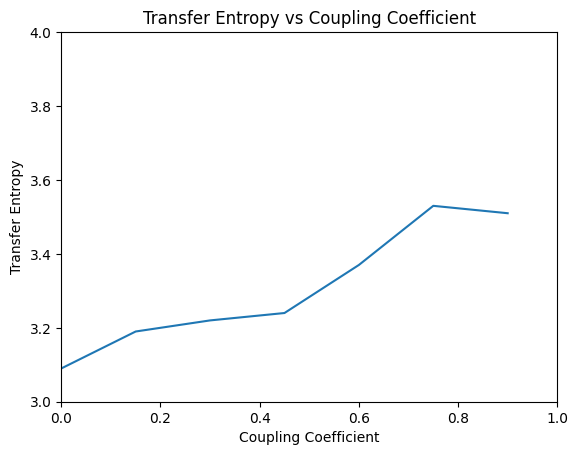

In [ ]:
# plotting the Transfer Entropy from X to Y vs Coupling coefficient

c = [0, 0.15, 0.30, 0.45, 0.60, 0.75, 0.90]
TE_X_to_y_val = [3.09, 3.19, 3.22, 3.24, 3.37, 3.53, 3.51]

plt.plot(c, TE_X_to_y_val)
plt.axis([0, 1, 3, 4])
plt.xlabel('Coupling Coefficient')
plt.ylabel('Transfer Entropy')
plt.title('Transfer Entropy vs Coupling Coefficient')
plt.show()

The second experiment was testing out how sensitive transfer entropy is to the bin count
<br>Bin count 2, TE = 0.54
<br>Bin count 3, TE = 0.69
<br>Bin count 5, TE = 1.62
<br>Bin count 8, TE = 2.31
<br>Bin count 13, TE = 3.025
<br>Bin count 21, TE = 3.829
<br>Bin count 34, TE = 4.93
<br>Bin count 55, TE = 6.229
<br>Bin count 89, TE = 8.02

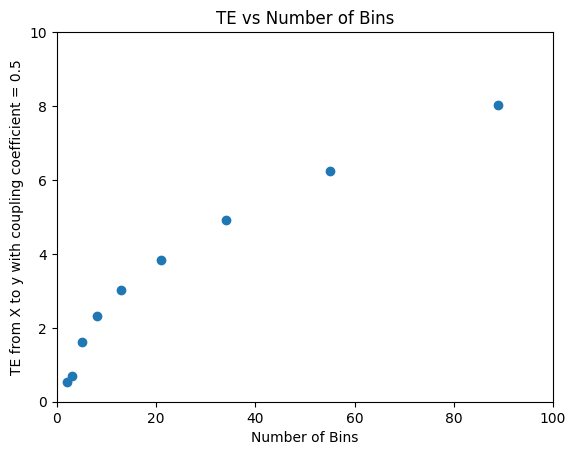

In [ ]:
# experimenting with bin count and coupling coefficient = 0.5

bin_count = [2, 3, 5, 8, 13, 21, 34, 55, 89]
TE_X_to_y = [0.54, 0.69, 1.62, 2.31, 3.025, 3.829, 4.93, 6.229, 8.02]

plt.scatter(bin_count, TE_X_to_y)
plt.axis([0, 100, 0, 10])
plt.xlabel('Number of Bins')
plt.ylabel('TE from X to y with coupling coefficient = 0.5')
plt.title('TE vs Number of Bins')
plt.show()

Third experiment is changing the number of data points generated to estimate the transfer entropy with coupling coefficient set as 0.5 and number of bins as 5
<br>datapoints = 10, TE = 2.2
<br>datapoints = 100, TE = 2.3
<br>datapoints = 500, TE = 1.87
<br>datapoints = 1000, TE = 1.75
<br>datapoints = 5000, TE = 1.6
<br>datapoints = 10000, TE = 1.58
<br>datapoints = 100000, TE = 1.45
<br>datapoints = 1000000, TE = 1.35
<br>datapoints = 10000000, TE = 1.24

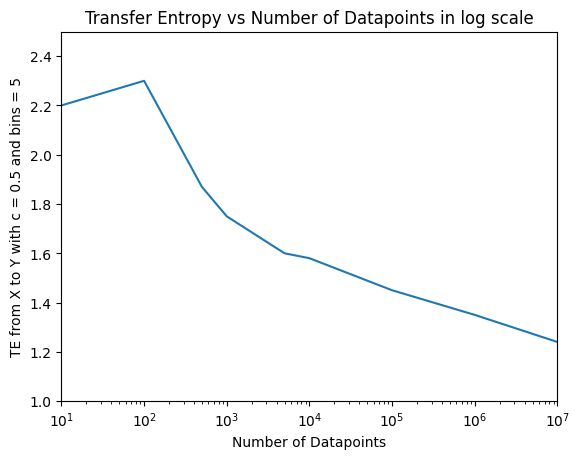

In [ ]:
# The Third experiment is changing the number of data points generated to estimate the transfer entropy 
# with coupling coefficient set as 0.5 and number of bins as 5

datapoints = [10, 100, 500, 1000, 5000, 10000, 100000, 1000000, 10000000]
TE_val = [2.2, 2.3, 1.87, 1.75, 1.6, 1.58, 1.45, 1.35, 1.24]

plt.plot(datapoints, TE_val)
plt.axis([10, 10000000, 1, 2.5])
plt.xscale('log')
plt.xlabel('Number of Datapoints')
plt.ylabel('TE from X to Y with c = 0.5 and bins = 5')
plt.title('Transfer Entropy vs Number of Datapoints in log scale')
plt.show()